In [1]:
from matplotlib import pyplot as plt
from isolated_pairs import PairsIsolated
from relative_isolated import PairsRelativeIsolated
from mutually_closest import PairsMutuallyClosest
from scipy.interpolate import interp1d
import pymaster as nmt
import sys
sys.path.append('../../xCell/')
import xcell
import scipy
import pyccl as ccl
import numpy as np
import healpy as hp

# Initiate the ccl cosmo class with the default LCDM parameters (Planck 18?)
cosmo = ccl.CosmologyVanillaLCDM()
pairs = {}

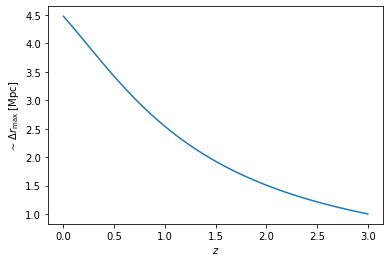

In [2]:
# Plot Delta r estimate based on z range
v_gal = 300 #km/s
z = np.linspace(0, 3)
H = 100 * 0.67 * cosmo.h_over_h0(1 / (1 + z)) #km/s/Mpc  # ccl works with scale factors
plt.plot(z, v_gal / H)
plt.xlabel('$z$')
plt.ylabel(r'$\sim \Delta r_{\rm max}$ [Mpc]')
plt.show()
plt.close()

# LRG

In [6]:
# Load catalog
cname = 'LRG'
fname = '../../../data/eBOSS_LRG_full_ALLdata-vDR16.fits'

# Find isolated pairs within a 1 Mpc radius 
radius_cut = 1 

pairs[cname] = {}
pairs[cname]['mclosest'] = PairsMutuallyClosest(fname, radius_cut)
pairs[cname]['isolated'] = PairsIsolated(fname, radius_cut)
pairs[cname]['rel_isolated'] = PairsRelativeIsolated(fname, radius_cut)

In [7]:
# Print column names
# cats['LRG'].dtype.names

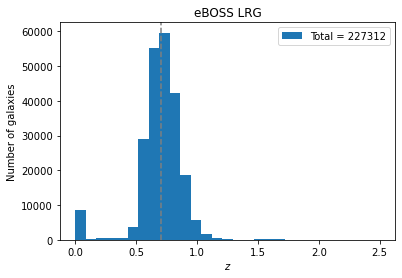

In [8]:
cname = 'LRG'

# Plot histogram of their redshifts and the mean redshift
z = pairs[cname]['mclosest'].cat['Z']
z_mean = np.mean(z)
plt.hist(z, bins=np.linspace(z.min(), 2.5, 30), label=f'Total = {z.size}');
plt.axvline(z_mean, ls='--', color='gray')
plt.xlabel(r'$z$')
plt.ylabel('Number of galaxies')
plt.title(f'eBOSS {cname}')
plt.legend()
plt.show()
plt.close()

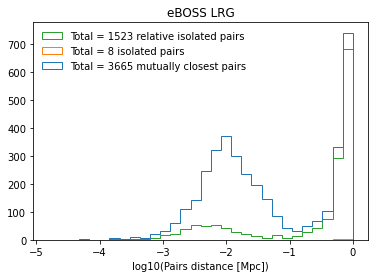

In [9]:
plt.hist([np.log10(pairs[cname]['mclosest'].get_pairs()['dist']),
          np.log10(pairs[cname]['isolated'].get_pairs()['dist']),
          np.log10(pairs[cname]['rel_isolated'].get_pairs()['dist'])
         ],
         bins=30, histtype='step',
         label=[f"Total = {pairs[cname]['mclosest'].get_pairs()['npairs']} mutually closest pairs",
                f"Total = {pairs[cname]['isolated'].get_pairs()['npairs']} isolated pairs",
                f"Total = {pairs[cname]['rel_isolated'].get_pairs()['npairs']} relative isolated pairs"])
plt.xlabel('log10(Pairs distance [Mpc])')
plt.legend(loc='upper left', frameon=False)
plt.title(f'eBOSS {cname}')
plt.show()
plt.close()

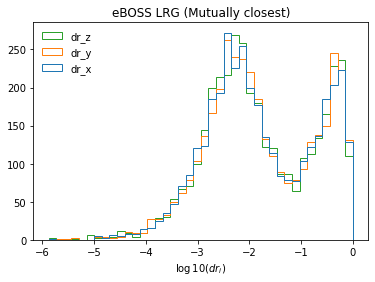

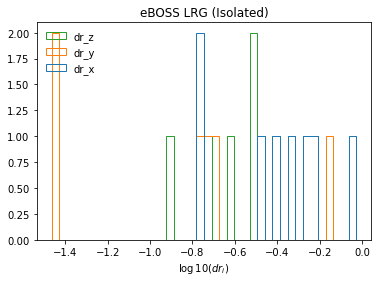

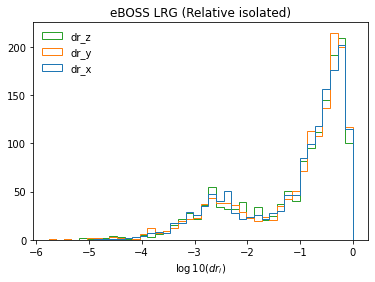

In [10]:
cname = 'LRG'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    train_sample_diff = pairs[cname][iso_type].get_ds()

    plt.hist([np.log10(np.abs(li[li !=0])).tolist() for li in np.array(train_sample_diff).T], bins=40,
             histtype='step', label=['dr_x', 'dr_y', 'dr_z'])
    plt.xlabel('$\log10(dr_i)$')
    plt.legend(loc='upper left', frameon=False)
    plt.title(f'eBOSS {cname} ({label})')
    plt.show()
    plt.close()

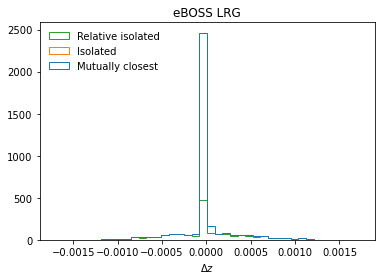

In [11]:
cname = 'LRG'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

dzs = []
for iso_type in iso_types:
    dzs.append(pairs[cname][iso_type].get_dz())

plt.hist(dzs, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta z$')
plt.legend(loc='upper left', frameon=False)
plt.title(f'eBOSS {cname}')
plt.show()
plt.close()

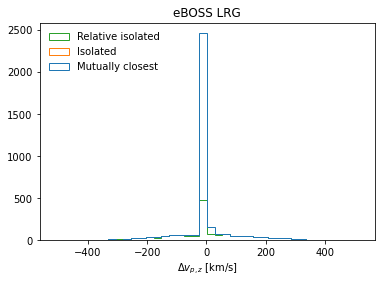

In [12]:
cname = 'LRG'
c = 3e5

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

vels = []
for iso_type in iso_types:
    vels.append(c * pairs[cname][iso_type].get_dz())

plt.hist(vels, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta v_{p,z}$ [km/s]')
plt.legend(loc='upper left', frameon=False)
plt.title(f'eBOSS {cname}')
plt.show()
plt.close()

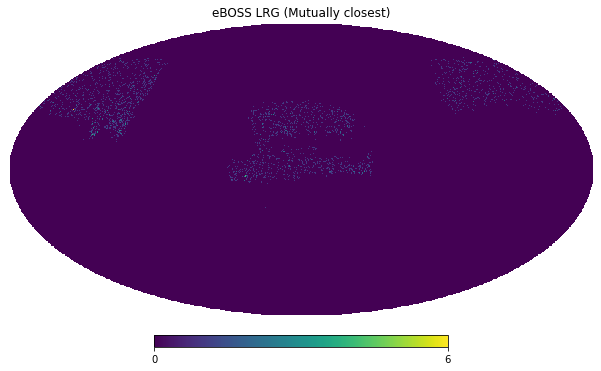

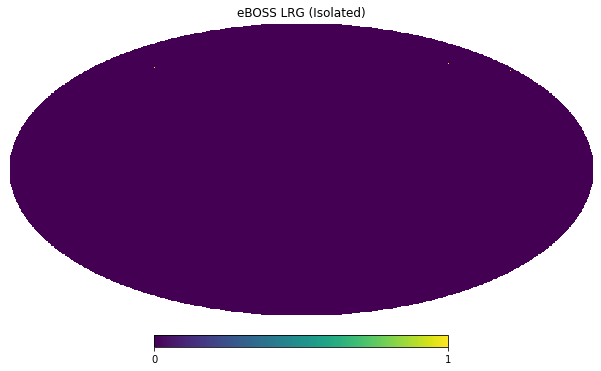

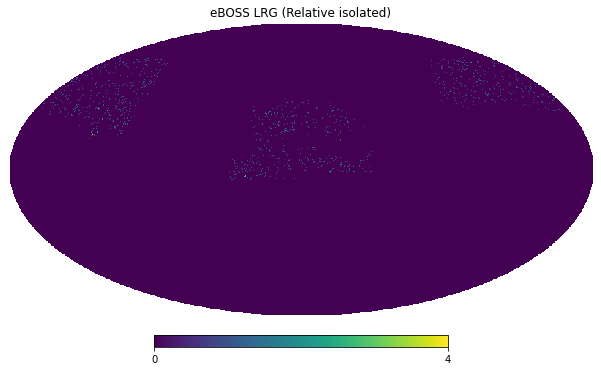

In [13]:
cname = 'LRG'
nside = 128

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    nc_map =  pairs[cname][iso_type].get_number_counts_map(nside)
    hp.mollview(nc_map, title=f'eBOSS {cname} ({label})')

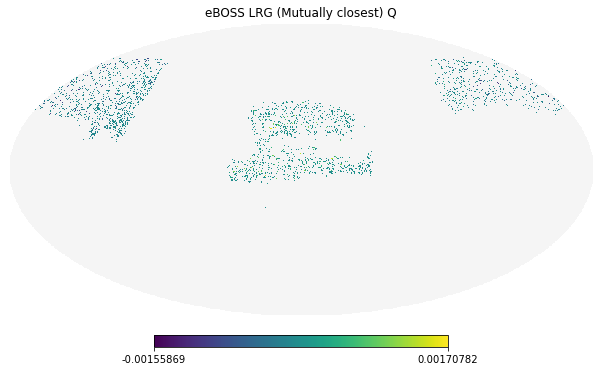

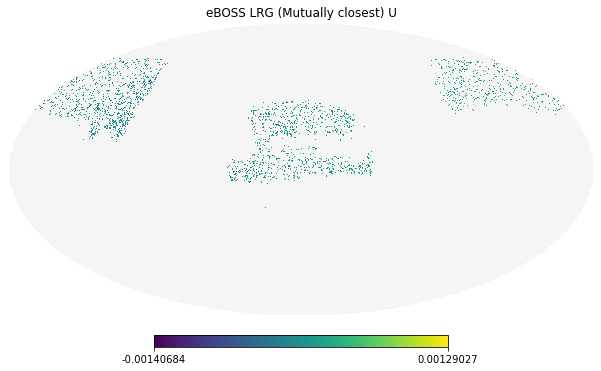

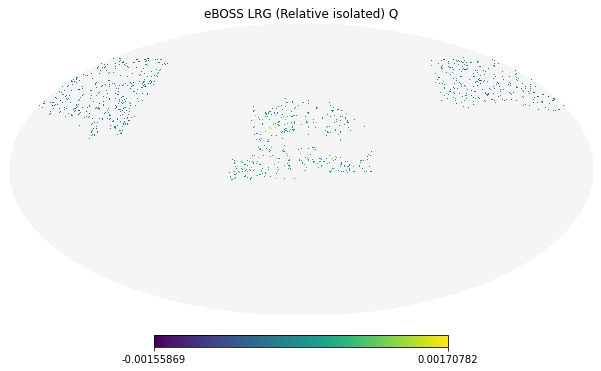

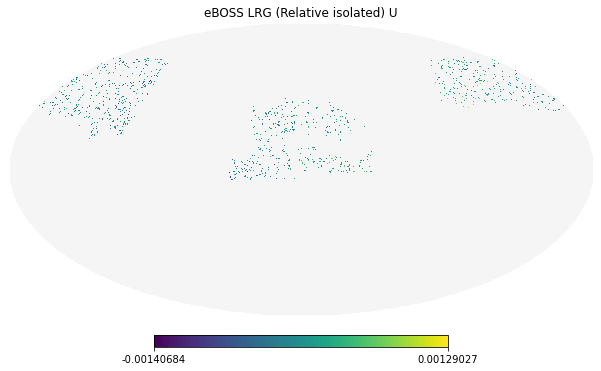

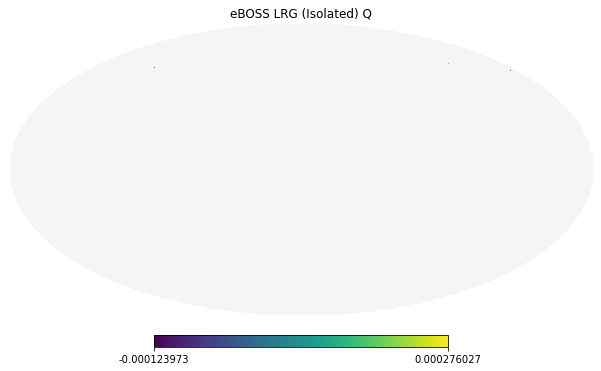

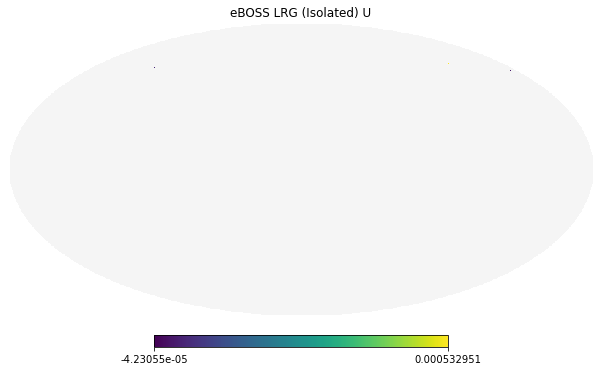

In [14]:
cname = 'LRG'
nside = 128
npix = hp.nside2npix(nside)

iso_types = ['mclosest', 'rel_isolated', 'isolated']
labels = ['Mutually closest', 'Relative isolated', 'Isolated']

for iso_type, label in zip(iso_types, labels):
    vort_map =  pairs[cname][iso_type].get_vorticity_map(nside, to_plot=True)
    hp.mollview(vort_map[0], title=f'eBOSS {cname} ({label}) Q', badcolor='whitesmoke')
    hp.mollview(vort_map[1], title=f'eBOSS {cname} ({label}) U', badcolor='whitesmoke')

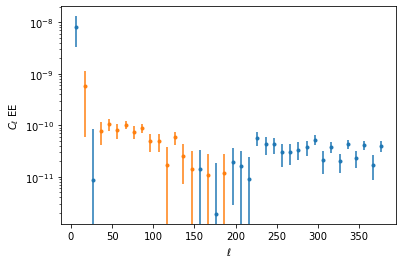

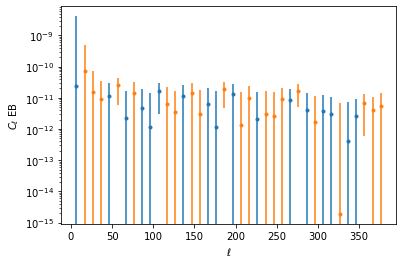

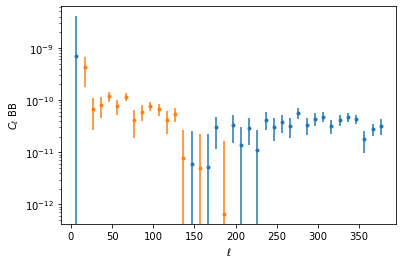

In [16]:
cname = 'LRG'
iso_type = 'rel_isolated'
nside = 128

b = nmt.NmtBin(nside, nlb=10)
nbpw = b.get_n_bands()

# Vorticity field
nc_map =  pairs[cname][iso_type].get_number_counts_map(nside).copy()
fsky_vv = np.mean(nc_map > 0)
mask_vv = nc_map
vort_map =  pairs[cname][iso_type].get_vorticity_map(nside).copy()
f = nmt.NmtField(mask_vv, vort_map, spin=1, n_iter=0)

# Cells auto (for the covariance estimation)
w_vv = nmt.NmtWorkspace()
w_vv.compute_coupling_matrix(f, f, b)
cl_vv_cp = nmt.compute_coupled_cell(f, f)
cl_vv = w_vv.decouple_cell(cl_vv_cp)
cl_vv_cov = cl_vv_cp / np.mean(mask_vv ** 2)

cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(f, f, f, f)

cov = nmt.covariance.gaussian_covariance(cw, 1, 1, 1, 1, cl_vv_cov, cl_vv_cov, cl_vv_cov, cl_vv_cov, w_vv, w_vv).reshape(nbpw, 4, nbpw, 4)

for i, l in zip(range(4), ['EE', 'EB', 'BE', 'BB']):
    if i == 2:
        continue
    ell = b.get_effective_ells()
    sigma = np.sqrt(np.diag(cov[:, i, :, i]))
    sel = cl_vv[i] > 0
    plt.errorbar(ell[sel], cl_vv[i][sel], yerr=sigma[sel], fmt='.')
    plt.errorbar(ell[~sel], -cl_vv[i][~sel], yerr=sigma[~sel], fmt='.')

    plt.xlabel(r'$\ell$')
    plt.ylabel(f'$C_\ell$ {l}')
    plt.yscale('log')
    plt.show()
    plt.close()

# CMASS

In [3]:
# Load catalog
cname = 'CMASS'
# cat1 = '../../../data/galaxy_DR12v5_CMASS_North.fits.gz'
# cat2 = '../../../data/galaxy_DR12v5_CMASS_South.fits.gz'
cat1 = '/mnt/extraspace/damonge/Datasets/BOSS/galaxy_DR12v5_CMASS_North.fits.gz'
cat2 = '/mnt/extraspace/damonge/Datasets/BOSS/galaxy_DR12v5_CMASS_South.fits.gz'
fname = [cat1, cat2]
# Find isolated pairs within a 1 Mpc radius 
radius_cut = 1 
pairs[cname] = {}
pairs[cname]['mclosest'] = PairsMutuallyClosest(fname, radius_cut)
pairs[cname]['isolated'] = PairsIsolated(fname, radius_cut)
pairs[cname]['rel_isolated'] = PairsRelativeIsolated(fname, radius_cut)

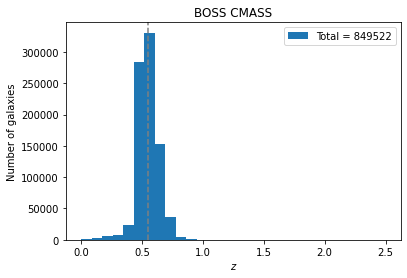

In [4]:
cname = 'CMASS'

# Plot histogram of their redshifts and the mean redshift
z = pairs[cname]['mclosest'].cat['Z']
z_mean = np.mean(z)
plt.hist(z, bins=np.linspace(z.min(), 2.5, 30), label=f'Total = {z.size}');
plt.axvline(z_mean, ls='--', color='gray')
plt.xlabel(r'$z$')
plt.ylabel('Number of galaxies')
plt.title(f'BOSS {cname}')
plt.legend()
plt.show()
plt.close()

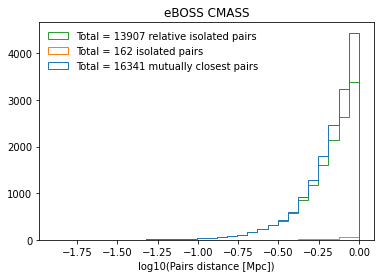

In [5]:
plt.hist([np.log10(pairs[cname]['mclosest'].get_pairs()['dist']),
          np.log10(pairs[cname]['isolated'].get_pairs()['dist']),
          np.log10(pairs[cname]['rel_isolated'].get_pairs()['dist'])
         ],
         bins=30, histtype='step',
         label=[f"Total = {pairs[cname]['mclosest'].get_pairs()['npairs']} mutually closest pairs",
                f"Total = {pairs[cname]['isolated'].get_pairs()['npairs']} isolated pairs",
                f"Total = {pairs[cname]['rel_isolated'].get_pairs()['npairs']} relative isolated pairs"])
plt.xlabel('log10(Pairs distance [Mpc])')
plt.legend(loc='upper left', frameon=False)
plt.title(f'eBOSS {cname}')
plt.show()
plt.close()

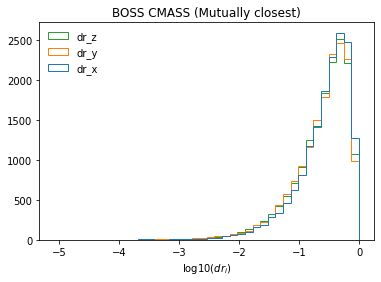

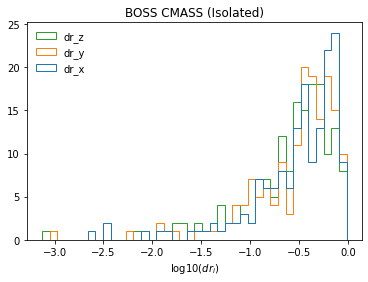

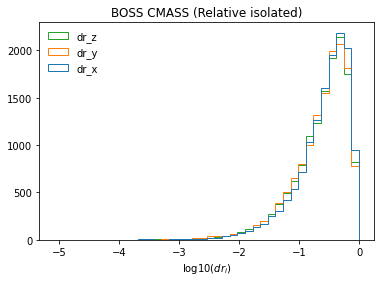

In [6]:
cname = 'CMASS'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    train_sample_diff = pairs[cname][iso_type].get_ds()

    plt.hist([np.log10(np.abs(li[li !=0])).tolist() for li in np.array(train_sample_diff).T], bins=40,
             histtype='step', label=['dr_x', 'dr_y', 'dr_z'])
    plt.xlabel('$\log10(dr_i)$')
    plt.legend(loc='upper left', frameon=False)
    plt.title(f'BOSS {cname} ({label})')
    plt.show()
    plt.close()

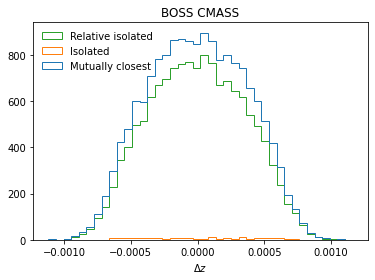

In [7]:
cname = 'CMASS'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

dzs = []
for iso_type in iso_types:
    dzs.append(pairs[cname][iso_type].get_dz())

plt.hist(dzs, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta z$')
plt.legend(loc='upper left', frameon=False)
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

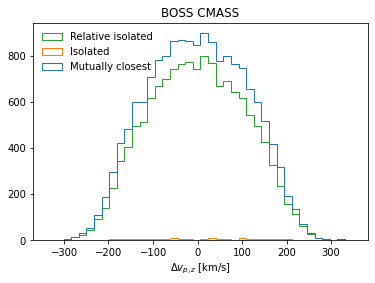

In [8]:
cname = 'CMASS'
c = 3e5

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

vels = []
for iso_type in iso_types:
    vels.append(c * pairs[cname][iso_type].get_dz())

plt.hist(vels, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta v_{p,z}$ [km/s]')
plt.legend(loc='upper left', frameon=False)
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

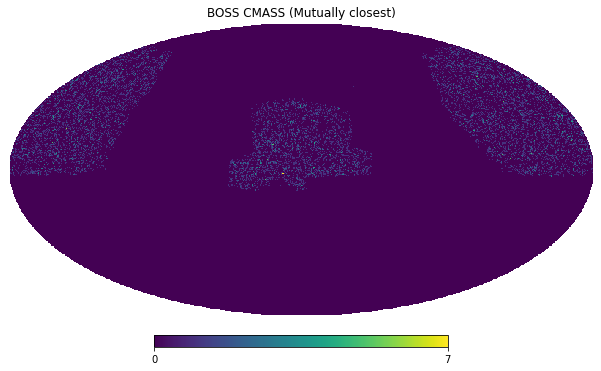

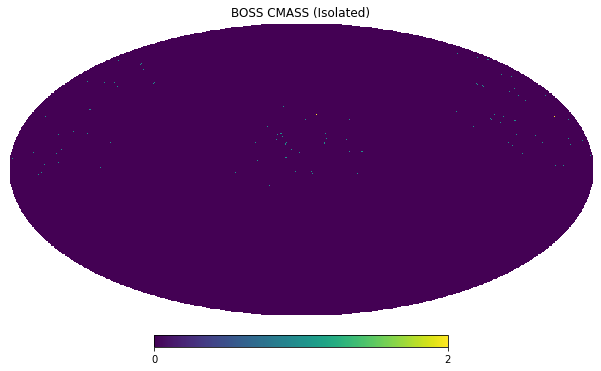

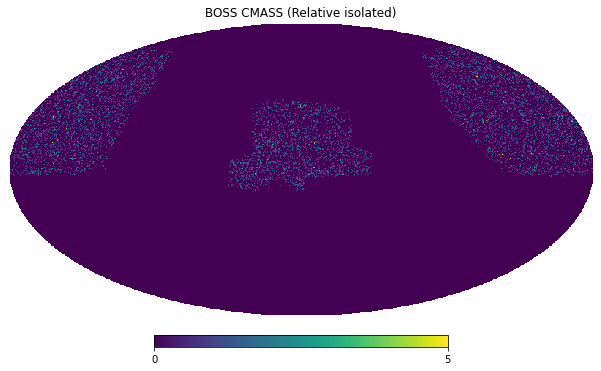

In [9]:
cname = 'CMASS'
nside = 128

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    nc_map =  pairs[cname][iso_type].get_number_counts_map(nside)
    hp.mollview(nc_map, title=f'BOSS {cname} ({label})')

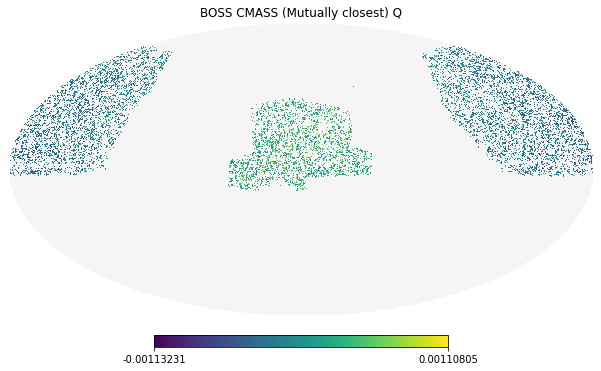

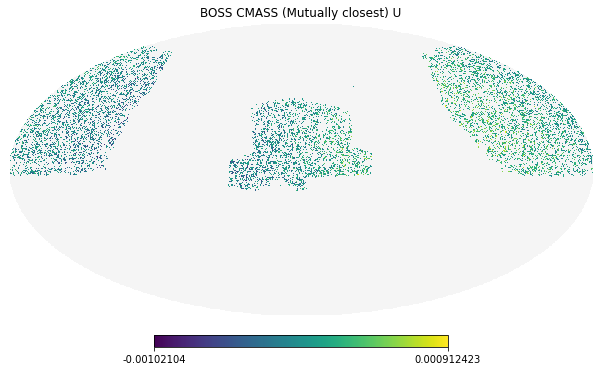

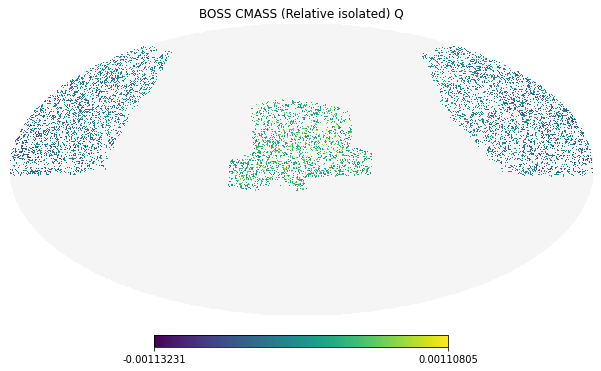

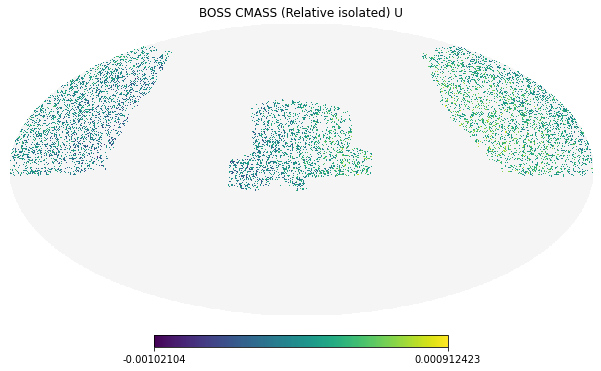

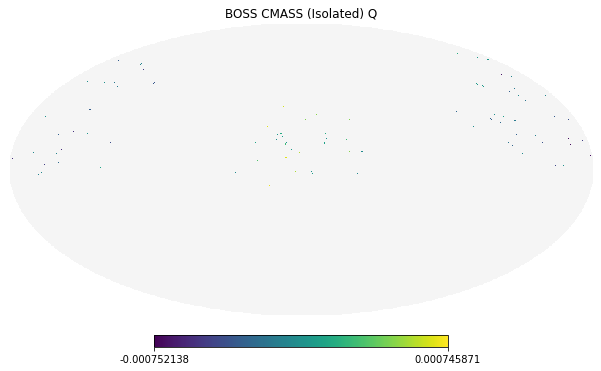

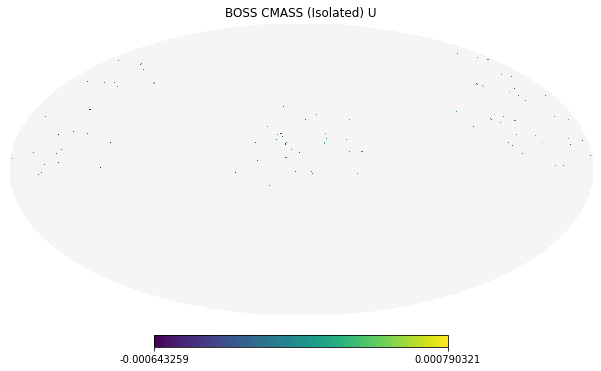

In [10]:
cname = 'CMASS'
nside = 128
npix = hp.nside2npix(nside)

iso_types = ['mclosest', 'rel_isolated', 'isolated']
labels = ['Mutually closest', 'Relative isolated', 'Isolated']

for iso_type, label in zip(iso_types, labels):
    vort_map =  pairs[cname][iso_type].get_vorticity_map(nside, to_plot=True)
    hp.mollview(vort_map[0], title=f'BOSS {cname} ({label}) Q', badcolor='whitesmoke')
    hp.mollview(vort_map[1], title=f'BOSS {cname} ({label}) U', badcolor='whitesmoke')

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt


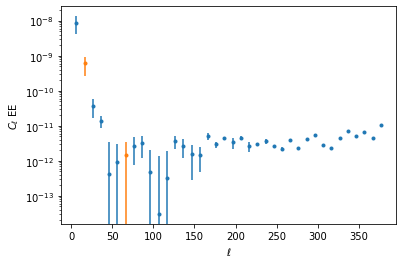

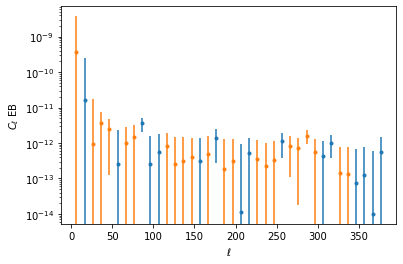

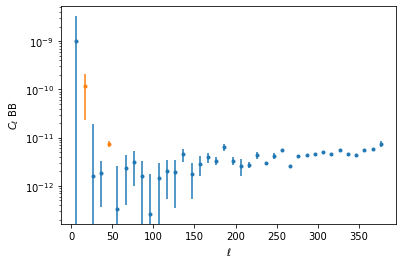

In [11]:
cname = 'CMASS'
iso_type = 'rel_isolated'
nside = 128

b = nmt.NmtBin(nside, nlb=10)
nbpw = b.get_n_bands()

# Vorticity field
nc_map =  pairs[cname][iso_type].get_number_counts_map(nside).copy()
fsky_vv = np.mean(nc_map > 0)
mask_vv = nc_map
vort_map =  pairs[cname][iso_type].get_vorticity_map(nside).copy()
f = nmt.NmtField(mask_vv, vort_map, spin=1, n_iter=0)

# Cells auto (for the covariance estimation)
w_vv = nmt.NmtWorkspace()
w_vv.compute_coupling_matrix(f, f, b)
cl_vv_cp = nmt.compute_coupled_cell(f, f)
cl_vv = w_vv.decouple_cell(cl_vv_cp)
cl_vv_cov = cl_vv_cp / np.mean(mask_vv ** 2)

cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(f, f, f, f)

cov = nmt.covariance.gaussian_covariance(cw, 1, 1, 1, 1, cl_vv_cov, cl_vv_cov, cl_vv_cov, cl_vv_cov, w_vv, w_vv).reshape(nbpw, 4, nbpw, 4)

for i, l in zip(range(4), ['EE', 'EB', 'BE', 'BB']):
    if i == 2:
        continue
    ell = b.get_effective_ells()
    sigma = np.sqrt(np.diag(cov[:, i, :, i]))
    sel = cl_vv[i] > 0
    plt.errorbar(ell[sel], cl_vv[i][sel], yerr=sigma[sel], fmt='.')
    plt.errorbar(ell[~sel], -cl_vv[i][~sel], yerr=sigma[~sel], fmt='.')

    plt.xlabel(r'$\ell$')
    plt.ylabel(f'$C_\ell$ {l}')
    plt.yscale('log')
    plt.show()
    plt.close()

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in sqrt


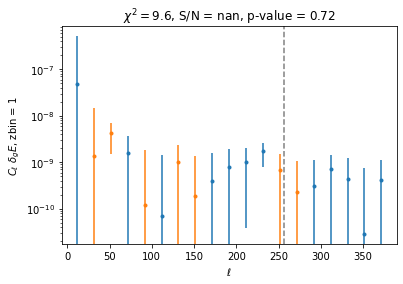

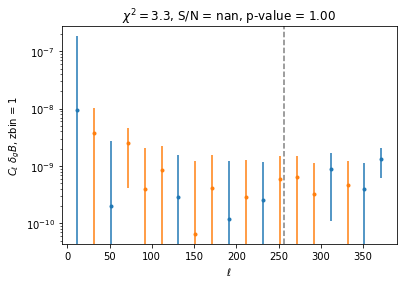

In [12]:
cname = 'CMASS'
iso_type = 'rel_isolated'
nside = 128

# Binning
nlb = 20
b = nmt.NmtBin(nside, nlb=nlb)
nbpw = b.get_n_bands()
lbpw = b.get_effective_ells()

# DELS field 
zbin = 1
bias = [1.13, 1.40, 1.35, 1.77][zbin]
config = {
    'data_catalogs':
      ['/mnt/extraspace/damonge/Datasets/DELS/Legacy_Survey_BASS-MZLS_galaxies-selection.fits',
       '/mnt/extraspace/damonge/Datasets/DELS/Legacy_Survey_DECALS_galaxies-selection.fits'],
    'zbin': zbin,
    'binary_mask': '/mnt/extraspace/damonge/Datasets/DELS/Legacy_footprint_final_mask_cut_decm36.fits',
    'completeness_map': '/mnt/extraspace/damonge/Datasets/DELS/Legacy_footprint_completeness_mask_128.fits',
    'star_map': '/mnt/extraspace/damonge/Datasets/DELS/allwise_total_rot_1024.fits',
    'nside': nside,
    'mask_name': 'mask_DELS_decm36',
    'mapper_class': 'MapperDELS',
    'path_rerun': '/mnt/extraspace/gravityls_3/xCell_output/rerun/DELS/',
    'bias': bias,  # Not used for anything because we are using the data itself for the covariance
    'coords': 'C'}
dels = xcell.mappers.MapperDELS(config)
fdels = dels.get_nmt_field()
mask_dels = dels.get_mask()
fsky_dels = np.mean(mask_dels > 0)

# Vorticity field
nc_map =  pairs[cname][iso_type].get_number_counts_map(nside).copy()
fsky_vv = np.mean(nc_map > 0)
mask_vv = nc_map
vort_map =  pairs[cname][iso_type].get_vorticity_map(nside).copy()
f = nmt.NmtField(mask_vv, vort_map, spin=1, n_iter=0)

# Cells auto (for the covariance estimation)
w_vv = nmt.NmtWorkspace()
w_vv.compute_coupling_matrix(f, f, b)
cl_vv_cp = nmt.compute_coupled_cell(f, f)
cl_vv = w_vv.decouple_cell(cl_vv_cp)
cl_vv_cov = cl_vv_cp / np.mean(mask_vv ** 2)

w_dd = nmt.NmtWorkspace()
w_dd.compute_coupling_matrix(fdels, fdels, b)
cl_dd_cp = nmt.compute_coupled_cell(fdels, fdels)
cl_dd = w_dd.decouple_cell(cl_dd_cp)
cl_dd_cov = cl_dd_cp / np.mean(mask_dels ** 2)

# Cells cross
fsky_vd = np.mean((nc_map > 0) & (mask_dels > 0))
w_vd = nmt.NmtWorkspace()
w_vd.compute_coupling_matrix(f, fdels, b)
cw_vd = nmt.NmtCovarianceWorkspace()
cw_vd.compute_coupling_coefficients(f, fdels, f, fdels)

cl_vd_cp = nmt.compute_coupled_cell(f, fdels)
cl_vd = w_vd.decouple_cell(cl_vd_cp)
cl_vd_cov = cl_vd_cp / np.mean(mask_vv * mask_dels)
cov = nmt.covariance.gaussian_covariance(cw_vd, 1, 0, 1, 0, cl_vv_cov, cl_vd_cov, cl_vd_cov, cl_dd_cov, w_vd, w_vd).reshape(nbpw, 2, nbpw, 2)
# cov_dE = np.diag(np.abs((cl_vv[0] * cl_dd[0] + cl_vd[0] **2)) / ((2 * lbpw + 1) * fsky_vd * nlb))
# cov_dB = np.diag(np.abs((cl_vv[1] * cl_dd[0] + cl_vd[1] **2)) / ((2 * lbpw + 1) * fsky_vd * nlb))

for i, l in zip(range(4), [r'$\delta_g E$', r'$\delta_g B$']):
    if i == 2:
        continue
    cov_i = cov[:, i, :, i]
#     cov_i = cov_dE if i == 0 else cov_dB
    sigma = np.sqrt(np.diag(cov_i))
    sel = cl_vd[i] > 0
    plt.errorbar(lbpw[sel], cl_vd[i, sel], yerr=sigma[sel], fmt='.')
    plt.errorbar(lbpw[~sel], -cl_vd[i, ~sel], yerr=sigma[~sel], fmt='.')
    
    sel = lbpw < 2 * nside
    chi2 = cl_vd[i, sel].dot(np.linalg.inv(cov_i[sel][:, sel]).dot(cl_vd[i, sel]))
    SN = np.sqrt(chi2 - cl_vd[i, sel].size)
    pvalue = 1 - scipy.stats.chi2.cdf(chi2, np.sum(sel))
    
    plt.axvline(2 * nside, color='gray', ls='--')
    plt.title(f'$\chi^2 = {chi2:.1f}$, S/N = {SN}, p-value = {pvalue:.2f}')
    plt.xlabel(r'$\ell$')
    plt.ylabel(f'$C_\ell$ {l}, zbin = {zbin}')
    plt.yscale('log')
    plt.show()
    plt.close()

# LOWZ

In [17]:
# Load catalog
cname = 'LOWZ'
fname = ['../../../data/galaxy_DR12v5_LOWZ_North.fits.gz', '../../../data/galaxy_DR12v5_LOWZ_South.fits.gz']
# fname = ['/mnt/extraspace/damonge/Datasets/BOSS/galaxy_DR12v5_LOWZ_North.fits.gz',
#          '/mnt/extraspace/damonge/Datasets/BOSS/galaxy_DR12v5_LOWZ_South.fits.gz']

# Find isolated pairs within a 1 Mpc radius 
radius_cut = 1 

pairs[cname] = {}
pairs[cname]['mclosest'] = PairsMutuallyClosest(fname, radius_cut)
pairs[cname]['isolated'] = PairsIsolated(fname, radius_cut)
pairs[cname]['rel_isolated'] = PairsRelativeIsolated(fname, radius_cut)

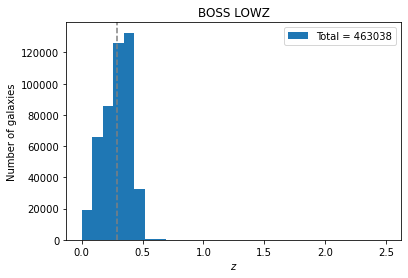

In [23]:
# Plot histogram of their redshifts and the mean redshift
z = pairs[cname]['mclosest'].cat['Z']
z_mean = np.mean(z)
plt.hist(z, bins=np.linspace(z.min(), 2.5, 30), label=f'Total = {z.size}');
plt.axvline(z_mean, ls='--', color='gray')
plt.xlabel(r'$z$')
plt.ylabel('Number of galaxies')
plt.title(f'BOSS {cname}')
plt.legend()
plt.show()
plt.close()

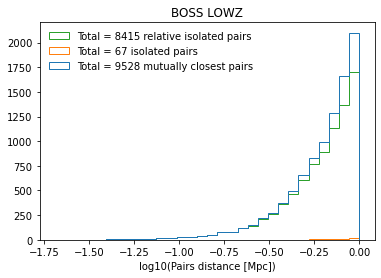

In [24]:
plt.hist([np.log10(pairs[cname]['mclosest'].get_pairs()['dist']),
          np.log10(pairs[cname]['isolated'].get_pairs()['dist']),
          np.log10(pairs[cname]['rel_isolated'].get_pairs()['dist'])
         ],
         bins=30, histtype='step',
         label=[f"Total = {pairs[cname]['mclosest'].get_pairs()['npairs']} mutually closest pairs",
                f"Total = {pairs[cname]['isolated'].get_pairs()['npairs']} isolated pairs",
                f"Total = {pairs[cname]['rel_isolated'].get_pairs()['npairs']} relative isolated pairs"])
plt.xlabel('log10(Pairs distance [Mpc])')
plt.legend(loc='upper left', frameon=False)
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

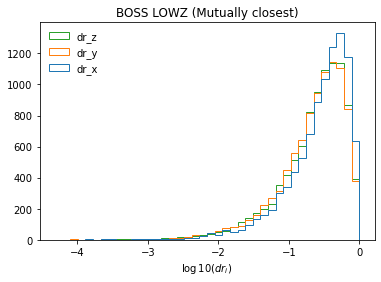

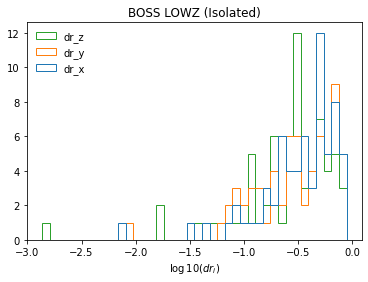

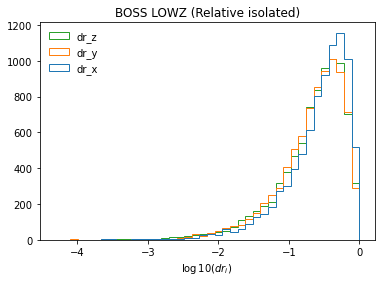

In [25]:
cname = 'LOWZ'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    train_sample_diff = pairs[cname][iso_type].get_ds()

    plt.hist([np.log10(np.abs(li[li !=0])).tolist() for li in np.array(train_sample_diff).T], bins=40,
             histtype='step', label=['dr_x', 'dr_y', 'dr_z'])
    plt.xlabel('$\log10(dr_i)$')
    plt.legend(loc='upper left', frameon=False)
    plt.title(f'BOSS {cname} ({label})')
    plt.show()
    plt.close()

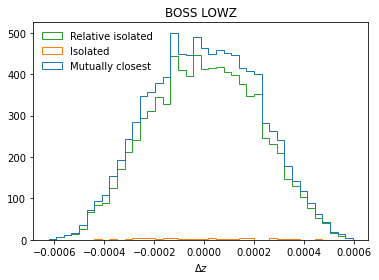

In [26]:
cname = 'LOWZ'

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

dzs = []
for iso_type in iso_types:
    dzs.append(pairs[cname][iso_type].get_dz())

plt.hist(dzs, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta z$')
plt.legend(loc='upper left', frameon=False)
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

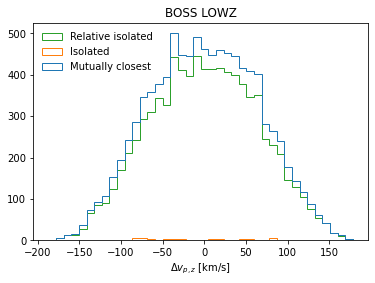

In [27]:
cname = 'LOWZ'
c = 3e5

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

vels = []
for iso_type in iso_types:
    vels.append(c * pairs[cname][iso_type].get_dz())

plt.hist(vels, bins=40,
         histtype='step', label=labels)
plt.xlabel('$\Delta v_{p,z}$ [km/s]')
plt.legend(loc='upper left', frameon=False)
plt.title(f'BOSS {cname}')
plt.show()
plt.close()

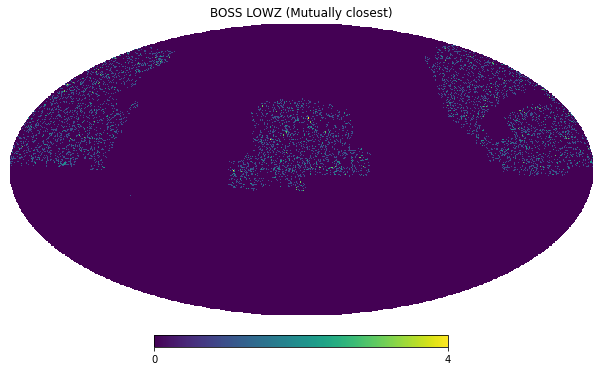

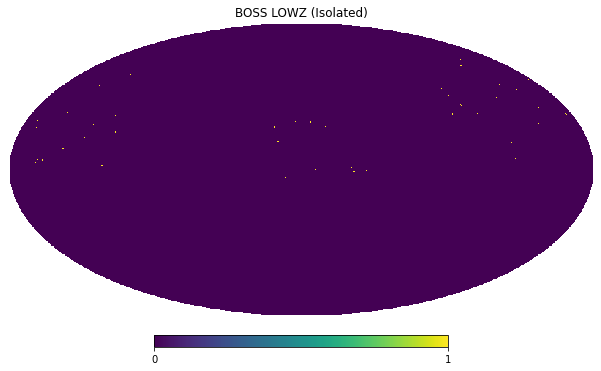

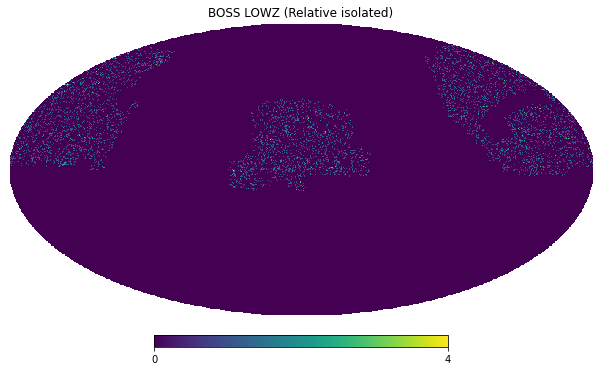

In [28]:
cname = 'LOWZ'
nside = 128

iso_types = ['mclosest', 'isolated', 'rel_isolated']
labels = ['Mutually closest', 'Isolated', 'Relative isolated']

for iso_type, label in zip(iso_types, labels):
    nc_map =  pairs[cname][iso_type].get_number_counts_map(nside)
    hp.mollview(nc_map, title=f'BOSS {cname} ({label})')

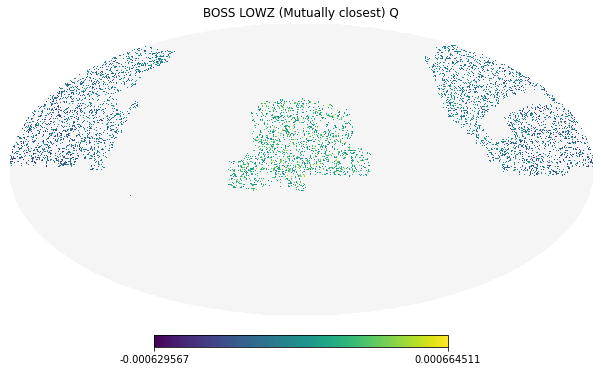

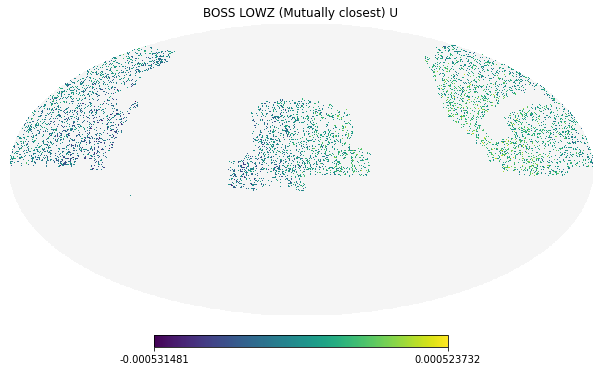

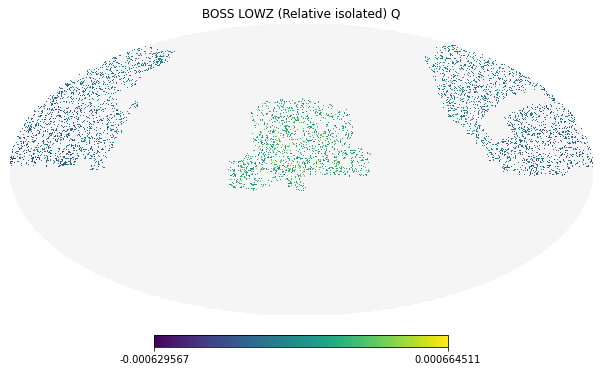

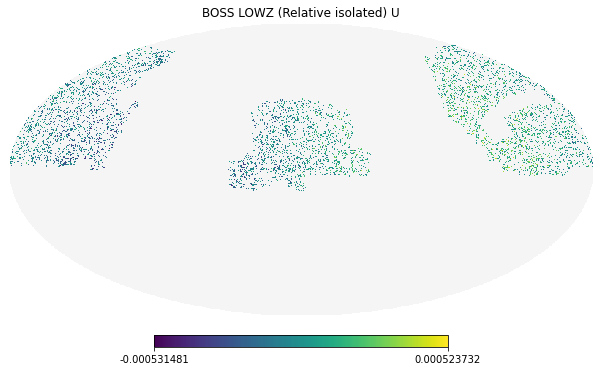

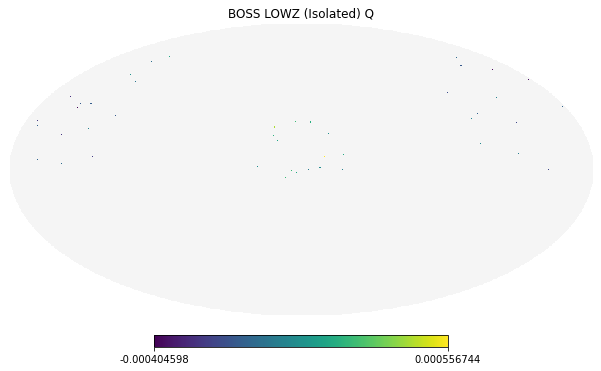

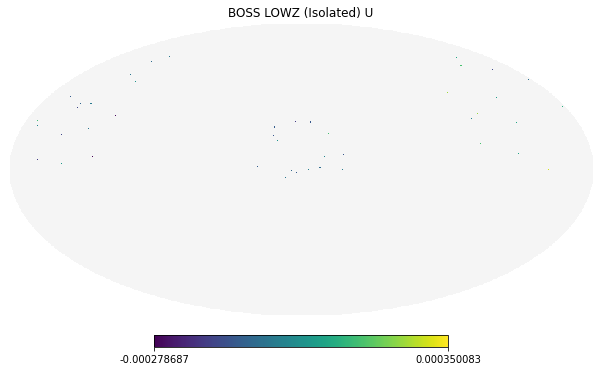

In [23]:
cname = 'LOWZ'
nside = 128
npix = hp.nside2npix(nside)

iso_types = ['mclosest', 'rel_isolated', 'isolated']
labels = ['Mutually closest', 'Relative isolated', 'Isolated']

for iso_type, label in zip(iso_types, labels):
    vort_map =  pairs[cname][iso_type].get_vorticity_map(nside, to_plot=True)
    hp.mollview(vort_map[0], title=f'BOSS {cname} ({label}) Q', badcolor='whitesmoke')
    hp.mollview(vort_map[1], title=f'BOSS {cname} ({label}) U', badcolor='whitesmoke')

/tmp/ipykernel_240446/2088336790.py:31: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(np.diag(cov[:, i, :, i]))


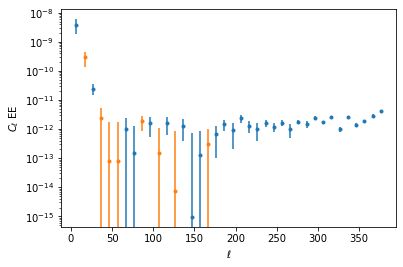

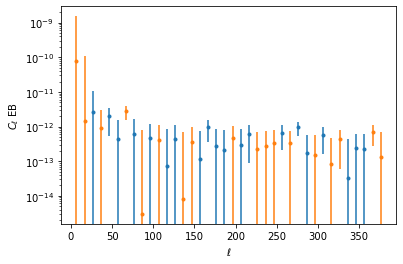

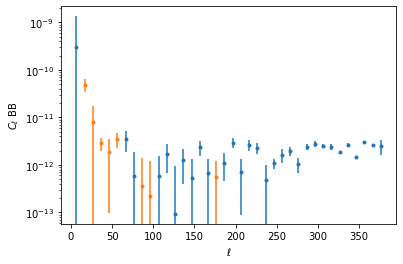

In [18]:
cname = 'LOWZ'
iso_type = 'rel_isolated'
nside = 128

b = nmt.NmtBin(nside, nlb=10)
nbpw = b.get_n_bands()

# Vorticity field
nc_map =  pairs[cname][iso_type].get_number_counts_map(nside).copy()
fsky_vv = np.mean(nc_map > 0)
mask_vv = nc_map
vort_map =  pairs[cname][iso_type].get_vorticity_map(nside).copy()
f = nmt.NmtField(mask_vv, vort_map, spin=1, n_iter=0)

# Cells auto (for the covariance estimation)
w_vv = nmt.NmtWorkspace()
w_vv.compute_coupling_matrix(f, f, b)
cl_vv_cp = nmt.compute_coupled_cell(f, f)
cl_vv = w_vv.decouple_cell(cl_vv_cp)
cl_vv_cov = cl_vv_cp / np.mean(mask_vv ** 2)

cw = nmt.NmtCovarianceWorkspace()
cw.compute_coupling_coefficients(f, f, f, f)

cov = nmt.covariance.gaussian_covariance(cw, 1, 1, 1, 1, cl_vv_cov, cl_vv_cov, cl_vv_cov, cl_vv_cov, w_vv, w_vv).reshape(nbpw, 4, nbpw, 4)

for i, l in zip(range(4), ['EE', 'EB', 'BE', 'BB']):
    if i == 2:
        continue
    ell = b.get_effective_ells()
    sigma = np.sqrt(np.diag(cov[:, i, :, i]))
    sel = cl_vv[i] > 0
    plt.errorbar(ell[sel], cl_vv[i][sel], yerr=sigma[sel], fmt='.')
    plt.errorbar(ell[~sel], -cl_vv[i][~sel], yerr=sigma[~sel], fmt='.')

    plt.xlabel(r'$\ell$')
    plt.ylabel(f'$C_\ell$ {l}')
    plt.yscale('log')
    plt.show()
    plt.close()

/mnt/zfsusers/gravityls_3/.local/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in sqrt


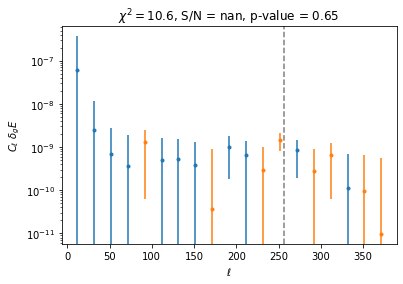

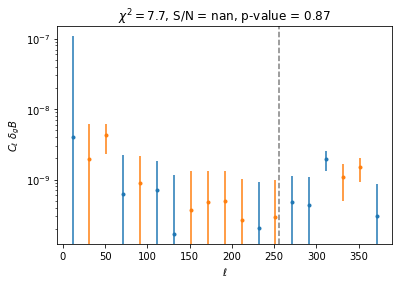

In [27]:
cname = 'LOWZ'
iso_type = 'rel_isolated'
nside = 128

# Binning
nlb = 20
b = nmt.NmtBin(nside, nlb=nlb)
nbpw = b.get_n_bands()
lbpw = b.get_effective_ells()

# DELS field 
zbin = 1
bias = [1.13, 1.40, 1.35, 1.77][zbin]
config = {
    'data_catalogs':
      ['/mnt/extraspace/damonge/Datasets/DELS/Legacy_Survey_BASS-MZLS_galaxies-selection.fits',
       '/mnt/extraspace/damonge/Datasets/DELS/Legacy_Survey_DECALS_galaxies-selection.fits'],
    'zbin': zbin,
    'binary_mask': '/mnt/extraspace/damonge/Datasets/DELS/Legacy_footprint_final_mask_cut_decm36.fits',
    'completeness_map': '/mnt/extraspace/damonge/Datasets/DELS/Legacy_footprint_completeness_mask_128.fits',
    'star_map': '/mnt/extraspace/damonge/Datasets/DELS/allwise_total_rot_1024.fits',
    'nside': nside,
    'mask_name': 'mask_DELS_decm36',
    'mapper_class': 'MapperDELS',
    'bias': bias,  # Not used for anything because we are using the data itself for the covariance
    'coords': 'C'}
dels = xcell.mappers.MapperDELS(config)
fdels = dels.get_nmt_field()
mask_dels = dels.get_mask()
fsky_dels = np.mean(mask_dels > 0)

# Vorticity field
nc_map =  pairs[cname][iso_type].get_number_counts_map(nside).copy()
fsky_vv = np.mean(nc_map > 0)
mask_vv = nc_map
vort_map =  pairs[cname][iso_type].get_vorticity_map(nside).copy()
f = nmt.NmtField(mask_vv, vort_map, spin=1, n_iter=0)

# Cells auto (for the covariance estimation)
w_vv = nmt.NmtWorkspace()
w_vv.compute_coupling_matrix(f, f, b)
cl_vv_cp = nmt.compute_coupled_cell(f, f)
cl_vv = w_vv.decouple_cell(cl_vv_cp)
cl_vv_cov = cl_vv_cp / np.mean(mask_vv ** 2)

w_dd = nmt.NmtWorkspace()
w_dd.compute_coupling_matrix(fdels, fdels, b)
cl_dd_cp = nmt.compute_coupled_cell(fdels, fdels)
cl_dd = w_dd.decouple_cell(cl_dd_cp)
cl_dd_cov = cl_dd_cp / np.mean(mask_dels ** 2)

# Cells cross
fsky_vd = np.mean((nc_map > 0) & (mask_dels > 0))
w_vd = nmt.NmtWorkspace()
w_vd.compute_coupling_matrix(f, fdels, b)
cw_vd = nmt.NmtCovarianceWorkspace()
cw_vd.compute_coupling_coefficients(f, fdels, f, fdels)

cl_vd_cp = nmt.compute_coupled_cell(f, fdels)
cl_vd = w_vd.decouple_cell(cl_vd_cp)
cl_vd_cov = cl_vd_cp / np.mean(mask_vv * mask_dels)
cov = nmt.covariance.gaussian_covariance(cw_vd, 1, 0, 1, 0, cl_vv_cov, cl_vd_cov, cl_vd_cov, cl_dd_cov, w_vd, w_vd).reshape(nbpw, 2, nbpw, 2)
# cov_dE = np.diag(np.abs((cl_vv[0] * cl_dd[0] + cl_vd[0] **2)) / ((2 * lbpw + 1) * fsky_vd * nlb))
# cov_dB = np.diag(np.abs((cl_vv[1] * cl_dd[0] + cl_vd[1] **2)) / ((2 * lbpw + 1) * fsky_vd * nlb))

for i, l in zip(range(4), [r'$\delta_g E$', r'$\delta_g B$']):
    if i == 2:
        continue
    cov_i = cov[:, i, :, i]
#     cov_i = cov_dE if i == 0 else cov_dB
    sigma = np.sqrt(np.diag(cov_i))
    sel = cl_vd[i] > 0
    plt.errorbar(lbpw[sel], cl_vd[i, sel], yerr=sigma[sel], fmt='.')
    plt.errorbar(lbpw[~sel], -cl_vd[i, ~sel], yerr=sigma[~sel], fmt='.')
    
    sel = lbpw < 2 * nside
    chi2 = cl_vd[i, sel].dot(np.linalg.inv(cov_i[sel][:, sel]).dot(cl_vd[i, sel]))
    SN = np.sqrt(chi2 - cl_vd[i, sel].size)
    pvalue = 1 - scipy.stats.chi2.cdf(chi2, np.sum(sel))
    
    plt.axvline(2 * nside, color='gray', ls='--')
    plt.title(f'$\chi^2 = {chi2:.1f}$, S/N = {SN}, p-value = {pvalue:.2f}')
    plt.xlabel(r'$\ell$')
    plt.ylabel(f'$C_\ell$ {l}')
    plt.yscale('log')
    plt.show()
    plt.close()